[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.2/107.7 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [4]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 5, in <module>
    from ultralytics.cfg import entrypoint
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/__init__.py", line 11, in <module>
    from ultralytics.models import NAS, RTDETR, SAM, YOLO, FastSAM, YOLOWorld
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/__init__.py", line 3, in <module>
    from .fastsam import FastSAM
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/fastsam/__init__.py", line 3, in <module>
    from .model import FastSAM
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/fastsam/model.py", line 5, in <module>
    from ultralytics.engine.model import Model
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 11, in <module>
    from ultralytics.cfg import TASK2DATA, get_cfg, get_save_dir
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 12, in <module>
    from 

**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

In [5]:
#from IPython.display import Image as IPyImage

#IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [8]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.8MB/s]



0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 427.1ms
Speed: 38.1ms preprocess, 427.1ms inference, 46.7ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [9]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]])

In [10]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875])

In [11]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.])

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [12]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

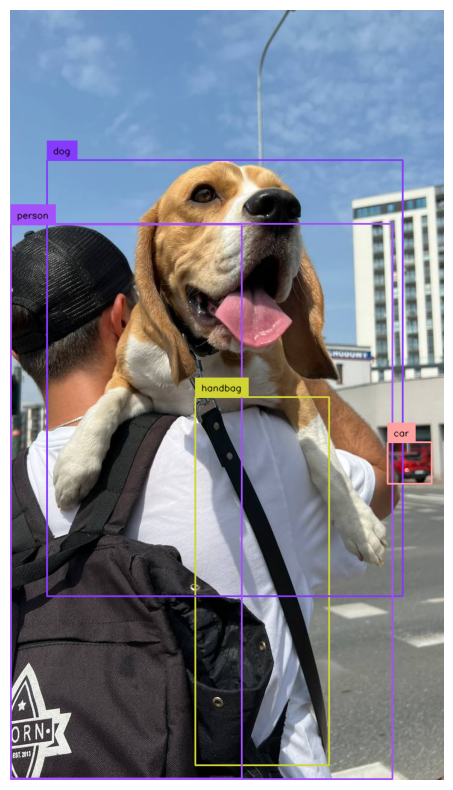

In [13]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [7]:
from google.colab import files

# kaggle.json dosyasını bilgisayarından seçip yükle
uploaded = files.upload()

# kaggle.json dosyasını uygun dizine taşı
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [34]:
!kaggle datasets download -d pandrii000/hituav-a-highaltitude-infrared-thermal-dataset


Dataset URL: https://www.kaggle.com/datasets/pandrii000/hituav-a-highaltitude-infrared-thermal-dataset
License(s): GNU Lesser General Public License 3.0
hituav-a-highaltitude-infrared-thermal-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [48]:
!unzip hituav-a-highaltitude-infrared-thermal-dataset.zip -d /content/datasets/


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/datasets/hit-uav/images/train/0_110_70_0_08486.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_03729.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_03734.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_08491.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_08512.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_08518.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_08520.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_80_0_08522.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_90_0_03784.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_90_0_03802.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_90_0_08527.jpg  
  inflating: /content/datasets/hit-uav/images/train/0_110_90_0_08529.jpg  
  inflating: /content/datasets/hit-uav/images/train/0

In [37]:
!ls /content/datasets/hit-uav


dataset.yaml  images  labels


In [38]:
!mv /content/datasets/hit-uav /content/datasets/yolov11


In [52]:
from ultralytics import YOLO

# YOLOv11 modelini yükle (eğer doğru model dosyasını indirip doğru formatta kullanıyorsanız)
model = YOLO("yolov11.pt")

# Modeli eğit
model.train(data="/content/datasets/yolov11/dataset.yaml", epochs=50, imgsz=640)


FileNotFoundError: '/path/to/yolov11.yaml' does not exist

In [13]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

#workspace = rf.workspace("liangdianzhong")
#project = workspace.project("-qvdww")
#version = project.version(3)
#dataset = version.download("yolov11")

project = rf.workspace("calib-buckton").project("infrared-6s0ke")
version = project.version(2)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to INFRARED-2 in yolov11:: 100%|██████████| 20464/20464 [00:03<00:00, 6004.91it/s]


## Custom Training

In [60]:
%cd /content

!yolo task=detect mode=train model=yolov11s.pt data=/content/datasets/yolov11/dataset.yaml epochs=10 imgsz=640 plots=True


/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 943, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 288, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load c

In [22]:
#%cd {HOME}

#!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

%cd /content

!yolo task=detect mode=train model=yolo11s.pt data=/content/datasets/data.yaml epochs=10 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.73 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [55]:
!ls {HOME}/runs/detect/train/

args.yaml  weights


In [56]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/train/confusion_matrix.png'

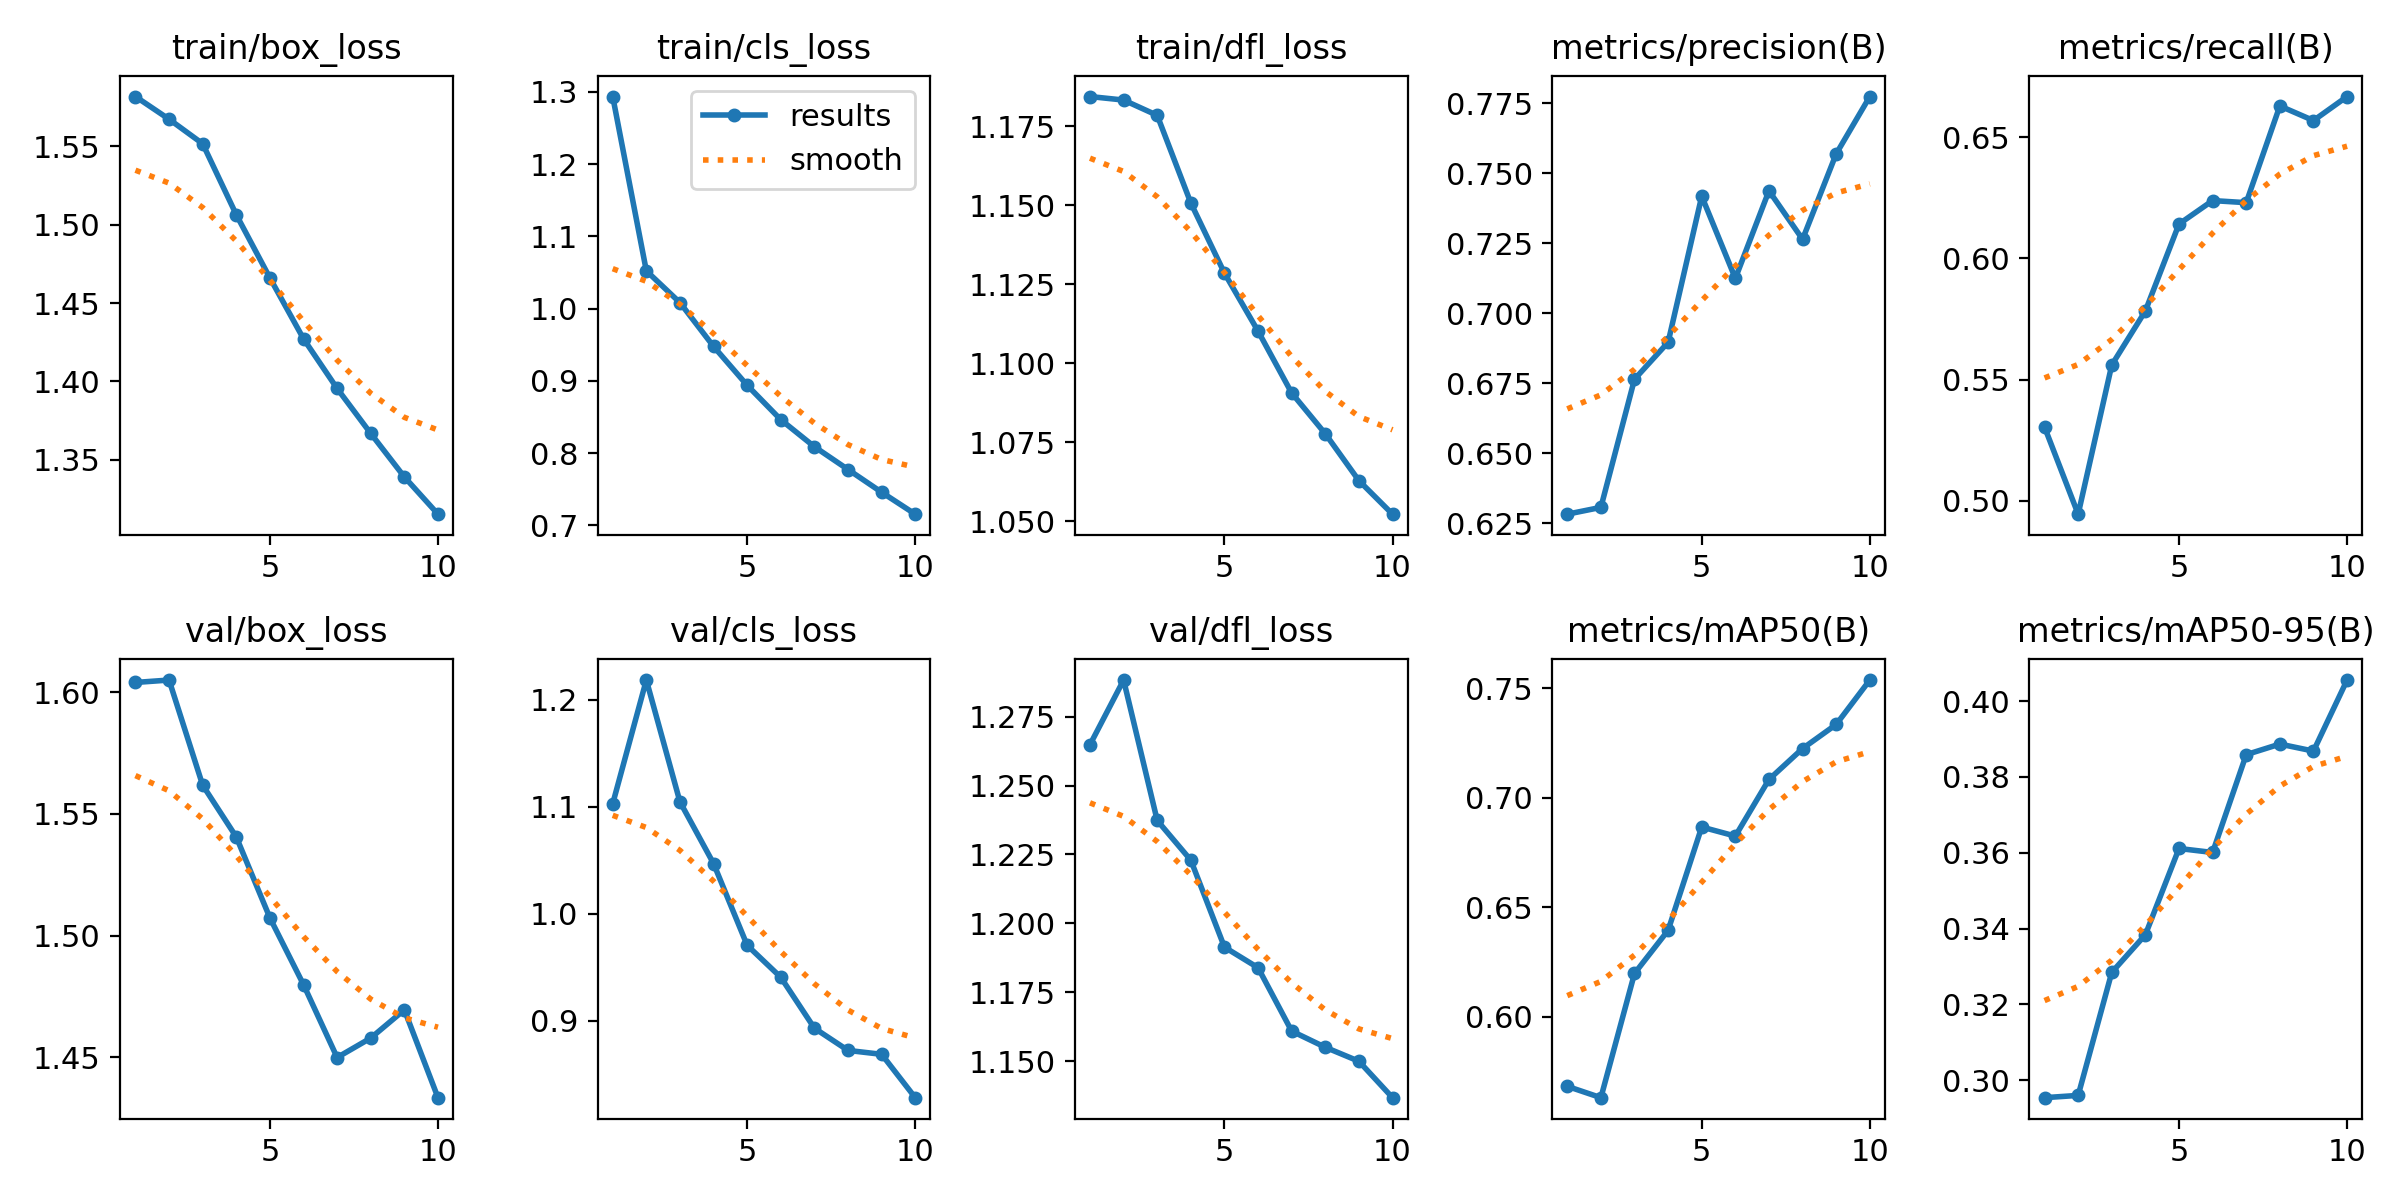

In [17]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

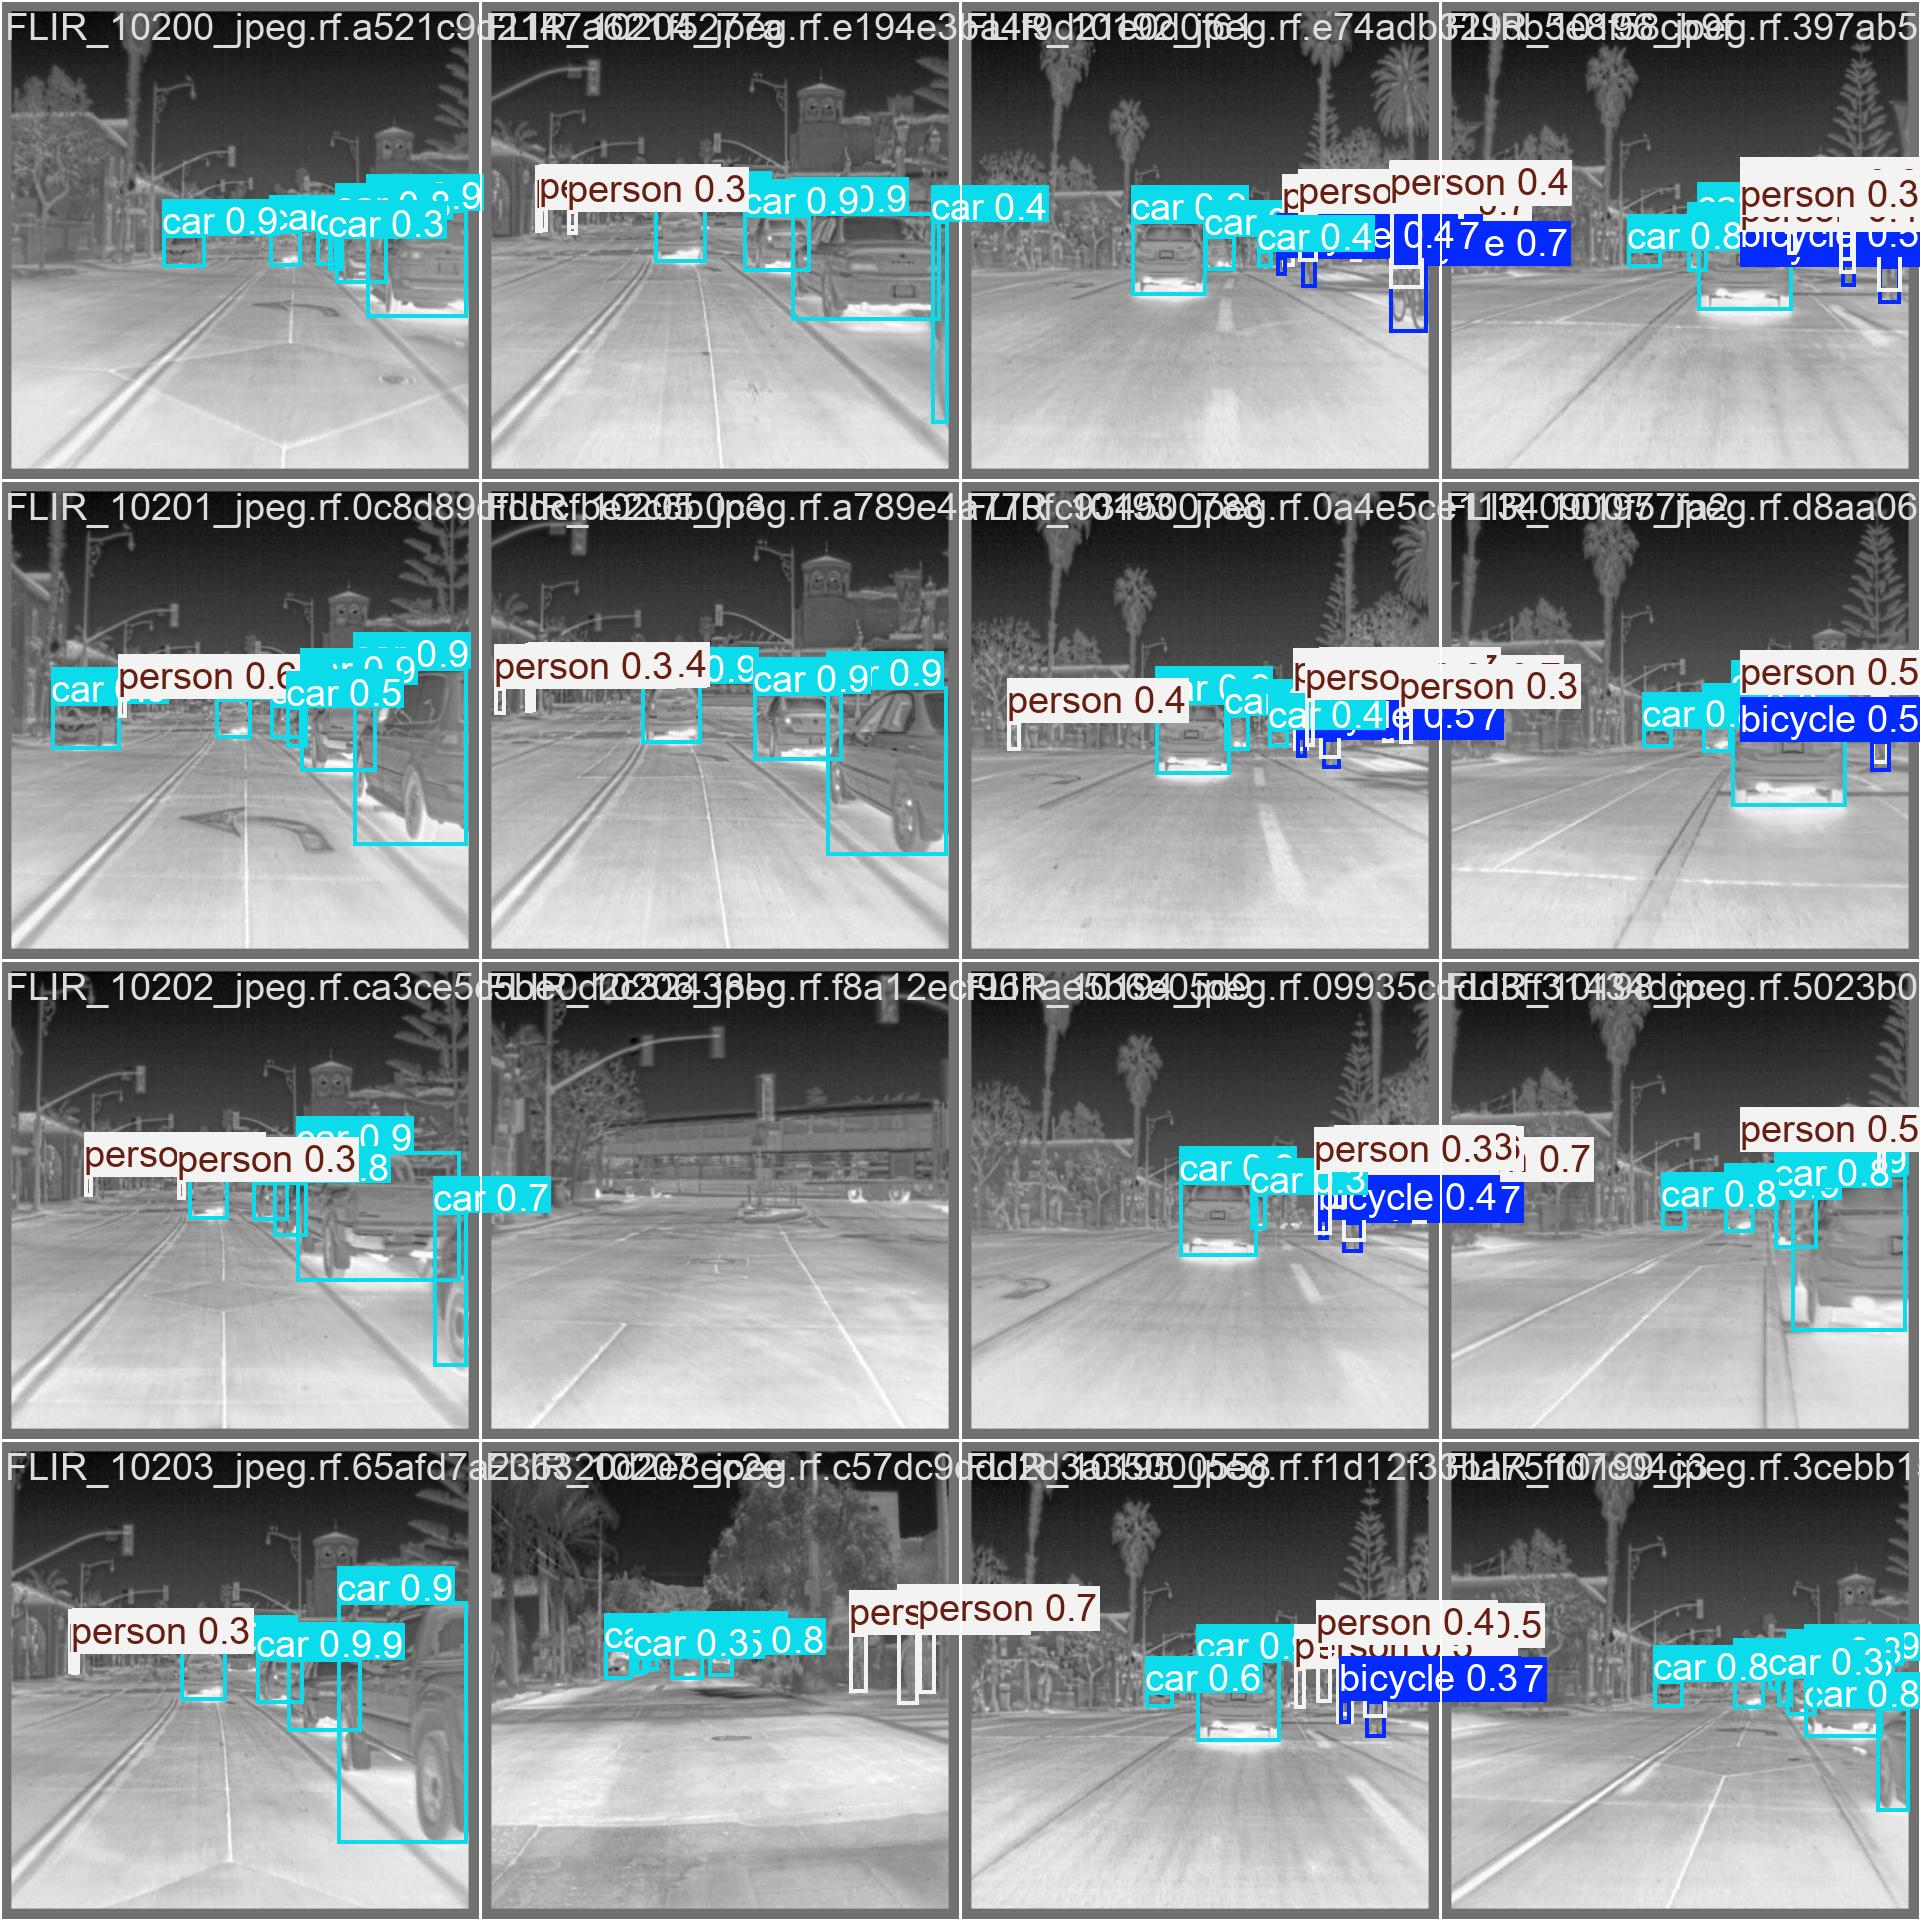

In [18]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [19]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/INFRARED-2/valid/labels.cache... 1365 images, 6 backgrounds, 0 corrupt: 100% 1365/1365 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/INFRARED-2/valid/images/FLIR_09042_jpeg.rf.2757e208bffe93a34b9e160afb0c46ca.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/INFRARED-2/valid/images/FLIR_09055_jpeg.rf.4224aa29bd4aedb72328036b470e1577.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/INFRARED-2/valid/images/FLIR_09653_jpeg.rf.3f83598c72ecdb16e1d1f3d3d9531580.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 86/86 [00:20<00:00,  4.11it/s]
                   all       1365      11674      0.768      0.672      0.755      0.406
               bicycle        338        470      0.695  

## Inference with custom model

In [20]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/1 /content/datasets/INFRARED-2/test/images/FLIR_09229_jpeg.rf.caffbcc97746224ecf6de2714fa661b0.jpg: 640x640 6 cars, 15.6ms
Speed: 5.1ms preprocess, 15.6ms inference, 159.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Let's take a look at few results.

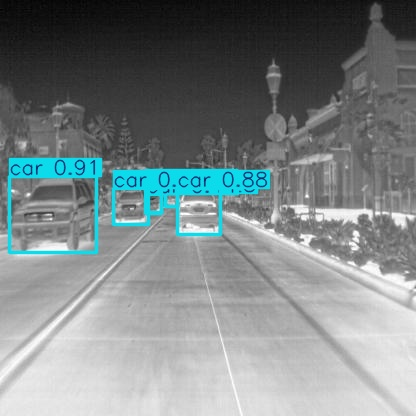

In [21]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [22]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

An error occured when getting the model upload URL: 404 Client Error: Not Found for url: https://api.roboflow.com/calib-buckton/infrared-6s0ke/2/uploadModel?api_key=VVr1tCMt7DuwT8Thjfu9&modelType=yolov11&nocache=true


In [23]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 970.7/970.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

Running inference on FLIR_09229_jpeg.rf.caffbcc97746224ecf6de2714fa661b0.jpg


Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'


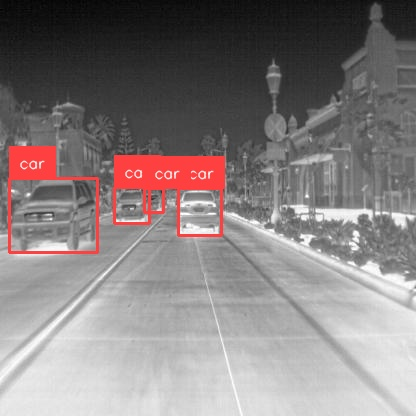

In [24]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.